In [2]:
# packages

import pathlib
import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.integrate as integrate
from scipy import signal
from scipy.optimize import fsolve
from scipy.interpolate import interp2d
from sympy import symbols, Eq, solve, I, cos, exp, pi
import os
os.chdir(os.path.abspath(''))


In [3]:
# READ DATA

# blade geometry
blade = pd.read_csv('bladedat.txt',delimiter='\t',header=None,names=['r','beta','c','t_perc'])
r_array = blade['r'] # radius [m]
beta_array = np.deg2rad(blade['beta']) # twist angle [rad]
c_array = blade['c'] # chord length [m]
t_perc_array = blade['t_perc'] # thickness ratio [%]

# mode shapes
modeshape = pd.read_csv('modeshapes.txt',delim_whitespace=True,header=2,names=['r', 'u1fy','u1fz','u1ey','u1ez', 'u2fy', 'u2fz', 'm'])
new_row = pd.DataFrame({'r': [2.8000], 'u1fy': [0], 'u1fz': [0], 'u1ey': [0], 'u1ez': [0], 'u2fy': [0], 'u2fz': [0], 'm': [1189.51],}) 
modeshape = pd.concat([new_row, modeshape]).reset_index(drop=True)

u1fy_array = modeshape['u1fy']
u1fz_array = modeshape['u1fz']
u1ey_array = modeshape['u1ey']
u1ez_array = modeshape['u1ez']
u2fy_array = modeshape['u2fy']
u2fz_array = modeshape['u2fz']
m_array = modeshape['m']

u1f_array = np.array([u1fy_array, u1fz_array]).T
u1e_array = np.array([u1ey_array, u1ez_array]).T
u2f_array = np.array([u2fy_array, u2fz_array]).T

omega1f=3.93
omega1e=6.10
omega2f=11.28

print(u1f_array.shape)

(18, 2)


In [4]:
# DATA GLOBAL

# # TIME SIMULATION PARAMETERS
# t_total = 100
# dt = 0.1 # time step size [s]
# num = int(t_total / dt)+1 # number of time steps

# NEWMARK COVERGENCE PARAMETERS
eps = 1e-3
step_max = 600


# GEOMETRIC PARAMETERS
B = 3 # number of blades
R = 89.17 # rotor diameter [m]
H = 119 # hub height [m]
Ls = 7.1 # length of nacelle [m]
a0 = 0 # tower radius [m] 

rho = 1.225 # air density [kg/m3]

# wind
nu = 0.0 # wind shear exponent
# V0 = 8 # mean wind speed at hub height [m/s]

# angles
theta_yaw = np.deg2rad(0) # yaw angle [rad]
theta_tilt = np.deg2rad(0) # tilt angle [rad]
theta_cone = np.deg2rad(0) # cone angle [rad]


# CONTROL
Ki = 0.64 #radians
Kp = 1.5 #radians
K1 = np.deg2rad(14)
I = 1.6e8
theta_pitch_min = 0
theta_pitch_max = np.deg2rad(45)
dtheta_pitch = np.deg2rad(9) #rad/s
omega_rated = 1.02265
omega_ref = 1.01 * omega_rated
P_rated = 10.64e6
lam = 8
c_P = 0.4662 #c_p optimal
K = 0.5 * rho * np.pi*R**2 * R**3 * c_P/lam**3
V_rated = (R*omega_rated)/lam


# STRUCTURAL
k_spring = 1.7e6
mass = 446e3
delta = 0.03
Newmark_beta = 0.27
Newmark_gamma = 0.51

GM1 = integrate.simpson(y=u1fy_array**2 * m_array , x=r_array) + integrate.simpson(y=u1fz_array**2 * m_array , x=r_array)
GM2 = integrate.simpson(y=u1ey_array**2 * m_array , x=r_array) + integrate.simpson(y=u1ez_array**2 * m_array , x=r_array)
GM3 = integrate.simpson(y=u2fy_array**2 * m_array , x=r_array) + integrate.simpson(y=u2fz_array**2 * m_array , x=r_array)

M_matrix = np.zeros((3,3))
M_matrix[0,0] = GM1
M_matrix[1,1] = GM2
M_matrix[2,2] = GM3

K_matrix = np.zeros((3,3))
K_matrix[0,0] = GM1*omega1f**2
K_matrix[1,1] = GM2*omega1e**2
K_matrix[2,2] = GM3*omega2f**2

C_matrix = np.zeros((3,3))
# C_matrix[0,0] = GM1*omega1f*delta/np.pi
# C_matrix[1,1] = GM2*omega1e*delta/np.pi
# C_matrix[2,2] = GM3*omega2f*delta/np.pi

C:\Users\nicol\AppData\Local\Temp\ipykernel_17588\2386931019.py:39: RuntimeWarning: invalid value encountered in sqrt
  omega_0 = np.sqrt(1/eigenval)
C:\Users\nicol\AppData\Local\Temp\ipykernel_17588\2386931019.py:65: RuntimeWarning: invalid value encountered in sqrt
  omega_0 = np.sqrt(1/eigenval)
c:\Users\nicol\Desktop\pythonfiles\myvenv\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\nicol\Desktop\pythonfiles\myvenv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Machine epsilon for 64-bit floating-point numbers: 2.220446049250313e-16


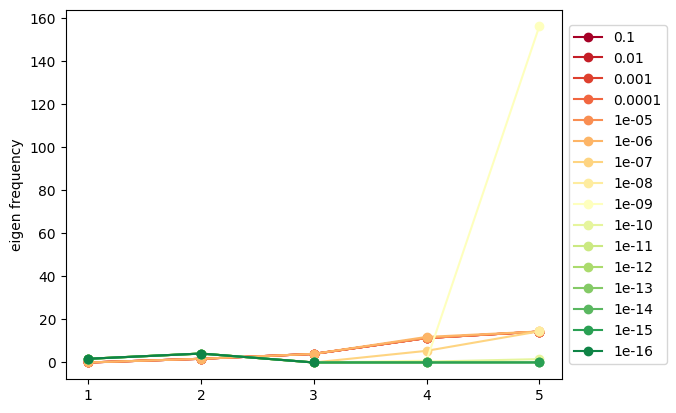

[1.71862590e+00 4.14789977e+00 1.38079633e-11 5.27129017e-03
 5.08027789e-02]


In [5]:
# 5 DOF

M5_matrix = np.zeros((5,5))
muz1f = integrate.simpson(y=m_array*u1fz_array , x=r_array)
muz1e = integrate.simpson(y=m_array*u1ez_array , x=r_array)
muz2f = integrate.simpson(y=m_array*u2fz_array , x=r_array)
mxuy1f = integrate.simpson(y=m_array*r_array*u1fy_array , x=r_array)
mxuy1e = integrate.simpson(y=m_array*r_array*u1ey_array , x=r_array)
mxuy2f = integrate.simpson(y=m_array*r_array*u2fy_array , x=r_array)
IM = integrate.simpson(y=m_array*r_array**2 , x=r_array)

M5_matrix[0,0] = mass + 3 * integrate.simpson(y=m_array , x=r_array)
M5_matrix[0,2] = muz1f
M5_matrix[0,3] = muz1e
M5_matrix[0,4] = muz2f 
M5_matrix[1,1] = IM
M5_matrix[1,2] = mxuy1f
M5_matrix[1,3] = mxuy1e
M5_matrix[1,4] = mxuy2f
M5_matrix[2,0] = muz1f
M5_matrix[2,1] = mxuy1f
M5_matrix[2,2] = GM1
M5_matrix[3,0] = muz1e
M5_matrix[3,1] = mxuy1e
M5_matrix[3,3] = GM2
M5_matrix[4,0] = muz2f
M5_matrix[4,1] = mxuy2f
M5_matrix[4,4] = GM3

K5_matrix = np.zeros((5,5))
K5_matrix[0,0] = k_spring
K5_matrix[1,1] = 1e-8
K5_matrix[2,2] = GM1*omega1f**2
K5_matrix[3,3] = GM2*omega1e**2
K5_matrix[4,4] = GM3*omega2f**2


eigenval, eigenvec =   np.linalg.eig(np.linalg.inv(K5_matrix) @ M5_matrix)
omega_0 = np.sqrt(1/eigenval)
#print('omega_0', omega_0)

#eigenval5 [3.29659580e-03  5.96919348e-02  5.24494276e+16 1.43425017e+00  4.10665851e-05] K5_matrix[1,1] = 1e-8
#eigenval5 [3.29653329e-03  5.96444381e-02  5.24494276e+27 -7.81738911e+10-1.76903343e+09] K5_matrix[1,1] = 1e-20
# omega_0  [1.74049350e+01 3.97413864e+00 1.38079633e-08            nan 1.39992000e+01]    K5_matrix[1,1] = 1e-8
#  omega_0 [1.74169164e+01 4.09463340e+00 1.38079633e-14            nan            nan]    K5_matrix[1,1] = 1e-20

#print(eigenvec)

eps = np.finfo(np.float64).eps
print("Machine epsilon for 64-bit floating-point numbers:", eps)


final = 17
exponent_range = np.arange(1, final)

x_plot = np.arange(1,6)
colors = plt.cm.RdYlGn(np.linspace(0, 1, final))


plt.figure(1)
for i in range(len(exponent_range)):
    exp =  10**(-float(exponent_range[i]))
    K5_matrix[1,1] = exp
    eigenval, eigenvec =  np.linalg.eig(np.linalg.inv(K5_matrix) @ M5_matrix)
    omega_0 = np.sqrt(1/eigenval)
    plt.plot(x_plot, omega_0, marker='o', label=exp, color=colors[i])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks([1, 2, 3, 4, 5], ['1', '2', '3', '4', '5'])
plt.ylabel('eigen frequency')
plt.xlabel('')
plt.show()

#print(eigenvec)


K5_matrix[1,1] = 10**-14
eigenval, eigenvec =  np.linalg.eig(np.linalg.inv(K5_matrix) @ M5_matrix)
omega_0 = np.sqrt(1/eigenval)
print(omega_0)



In [12]:
# eigenvvalue problem for 4 DOF

muz1f = integrate.simpson(y=m_array*u1fz_array , x=r_array)
muz1e = integrate.simpson(y=m_array*u1ez_array , x=r_array)
muz2f = integrate.simpson(y=m_array*u2fz_array , x=r_array)
mxuy1f = integrate.simpson(y=m_array*r_array*u1fy_array , x=r_array)
mxuy1e = integrate.simpson(y=m_array*r_array*u1ey_array , x=r_array)
mxuy2f = integrate.simpson(y=m_array*r_array*u2fy_array , x=r_array)

# M matrix
M4_matrix = np.zeros((4,4))
M4_matrix[0,0] = mass + 3 * integrate.simpson(y=m_array , x=r_array)
M4_matrix[0,1] = muz1f
M4_matrix[0,2] = muz1e
M4_matrix[0,3] = muz2f 
M4_matrix[1,0] = muz1f
M4_matrix[1,1] = GM1
M4_matrix[2,0] = muz1e
M4_matrix[2,2] = GM2
M4_matrix[3,0] = muz2f
M4_matrix[3,3] = GM3

# K matrix
K4_matrix = np.zeros((4,4))
K4_matrix[0,0] = k_spring
K4_matrix[1,1] = GM1*omega1f**2
K4_matrix[2,2] = GM2*omega1e**2
K4_matrix[3,3] = GM3*omega2f**2

# eigen 
eigenval, eigenvec =   np.linalg.eig(np.linalg.inv(K4_matrix) @ M4_matrix)

eigenomega = np.sqrt(1/eigenval)
eigen_0 = np.sqrt(k_spring/M4_matrix[0,0])

print('eigenomega', eigenomega)
print('natural freq', eigen_0)
print(f'difference: {(eigenomega[0] - eigen_0)/ eigenomega[0]*100:.3} % ')
print('')

# eigen vectors analysis
max_array = np.max(abs(eigenvec), axis=0)
eigenvec = np.divide(eigenvec, max_array)

with np.printoptions(precision=5, suppress=True):
    print('normalized eigenvec')
    print(eigenvec)




eigenomega [ 1.71861048  3.97296447 11.35748775  6.10020565]
natural freq 1.7224340407425118
difference: -0.222 % 

normalized eigenvec
[[-1.      -0.00817 -0.00404 -0.00052]
 [-0.62263  1.       0.0121   0.00234]
 [ 0.01118  0.00078 -0.00074 -1.     ]
 [ 0.0799   0.00389 -1.       0.00072]]
